In [6]:
import sys

sys.path.append("../..")
from src.data_loaders.data_paths import get_data_root
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.models.helpers import split_data
from src.models.models import XGBoostModel
from src.data_loaders.datasets import Datasets

In [7]:
df = pd.read_csv(get_data_root() / "evaluation_full_2.csv")

v3


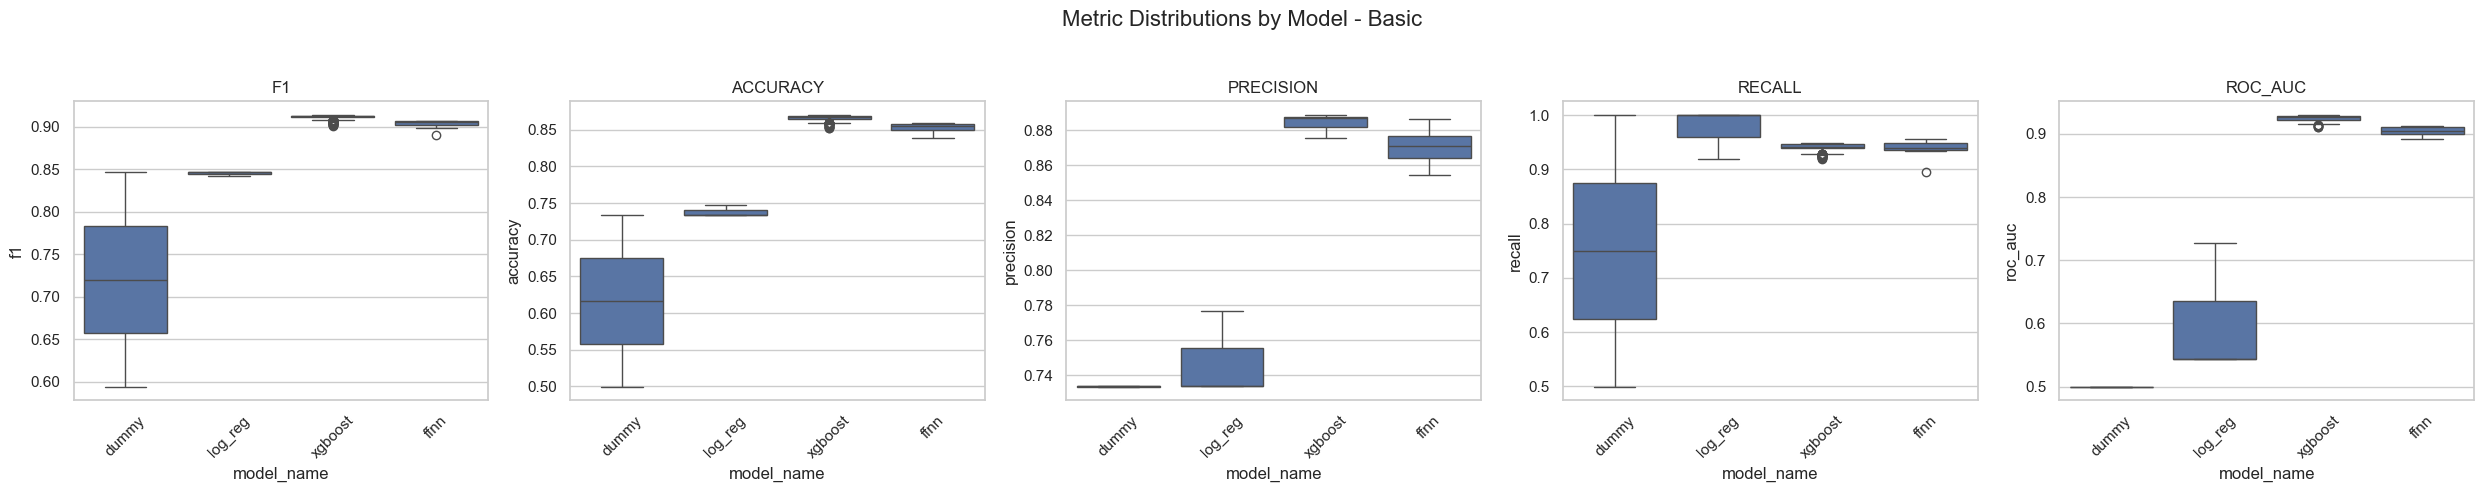

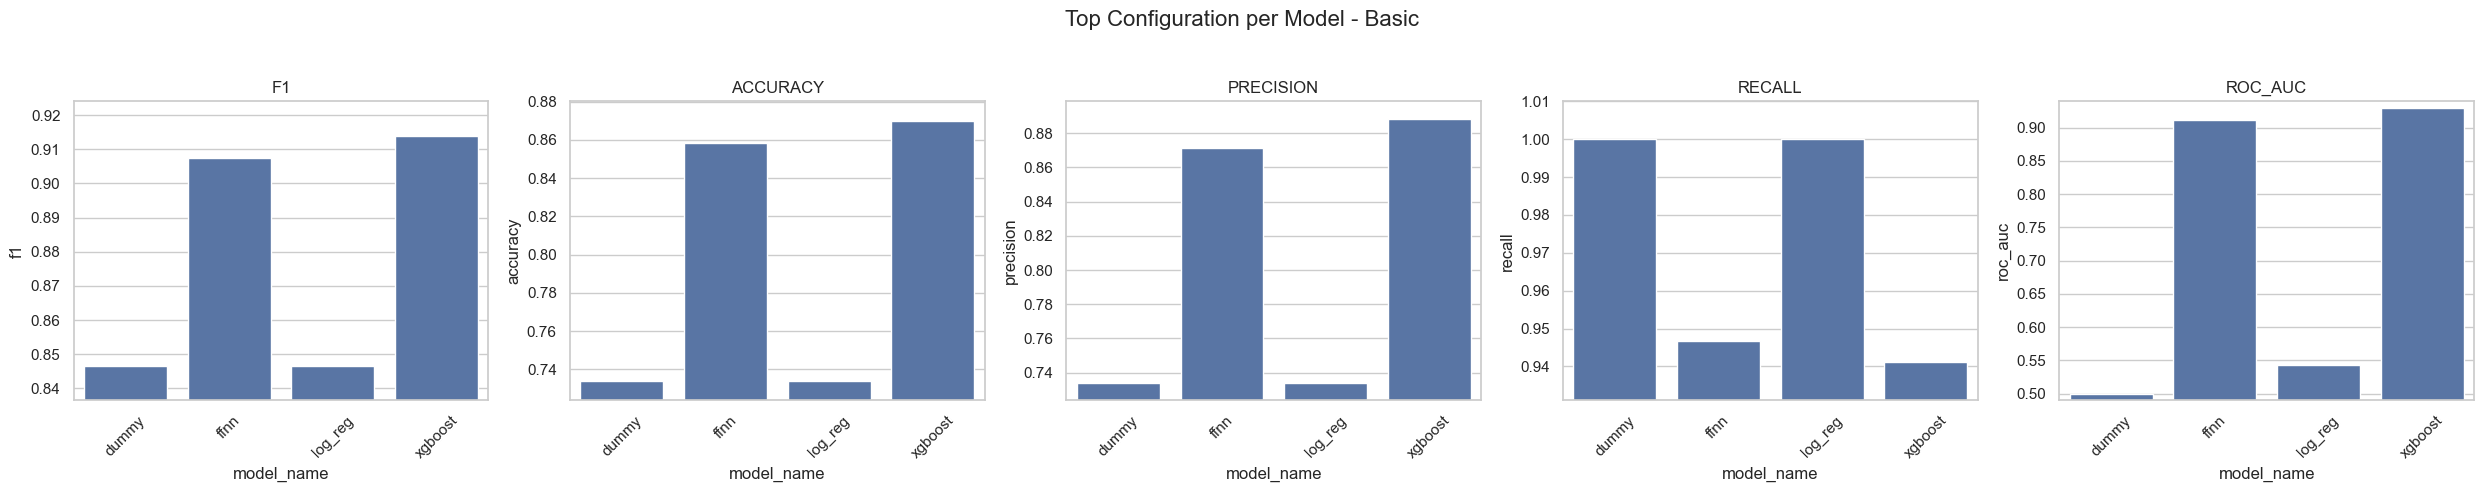

v6


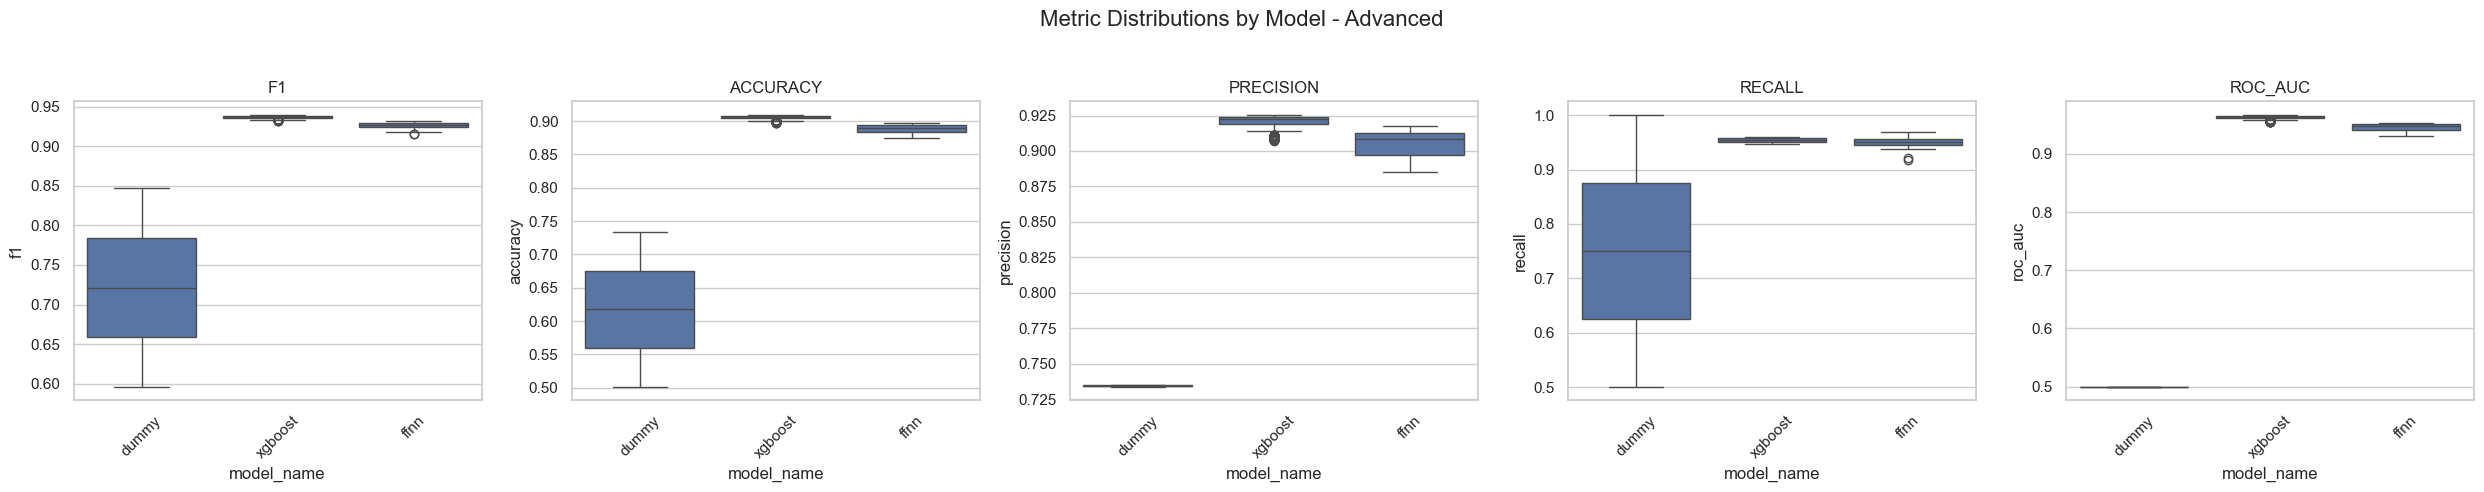

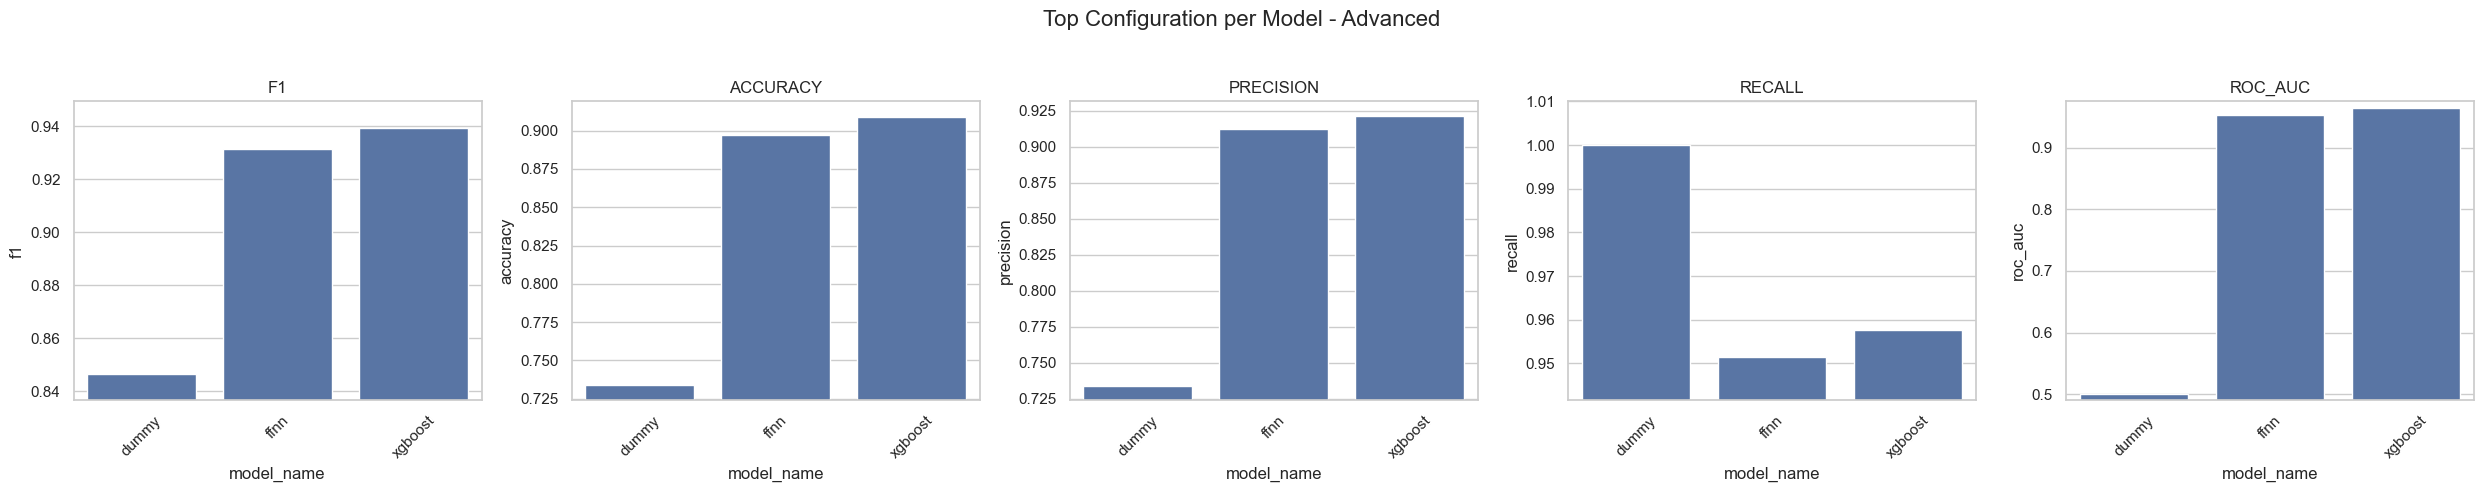

pass


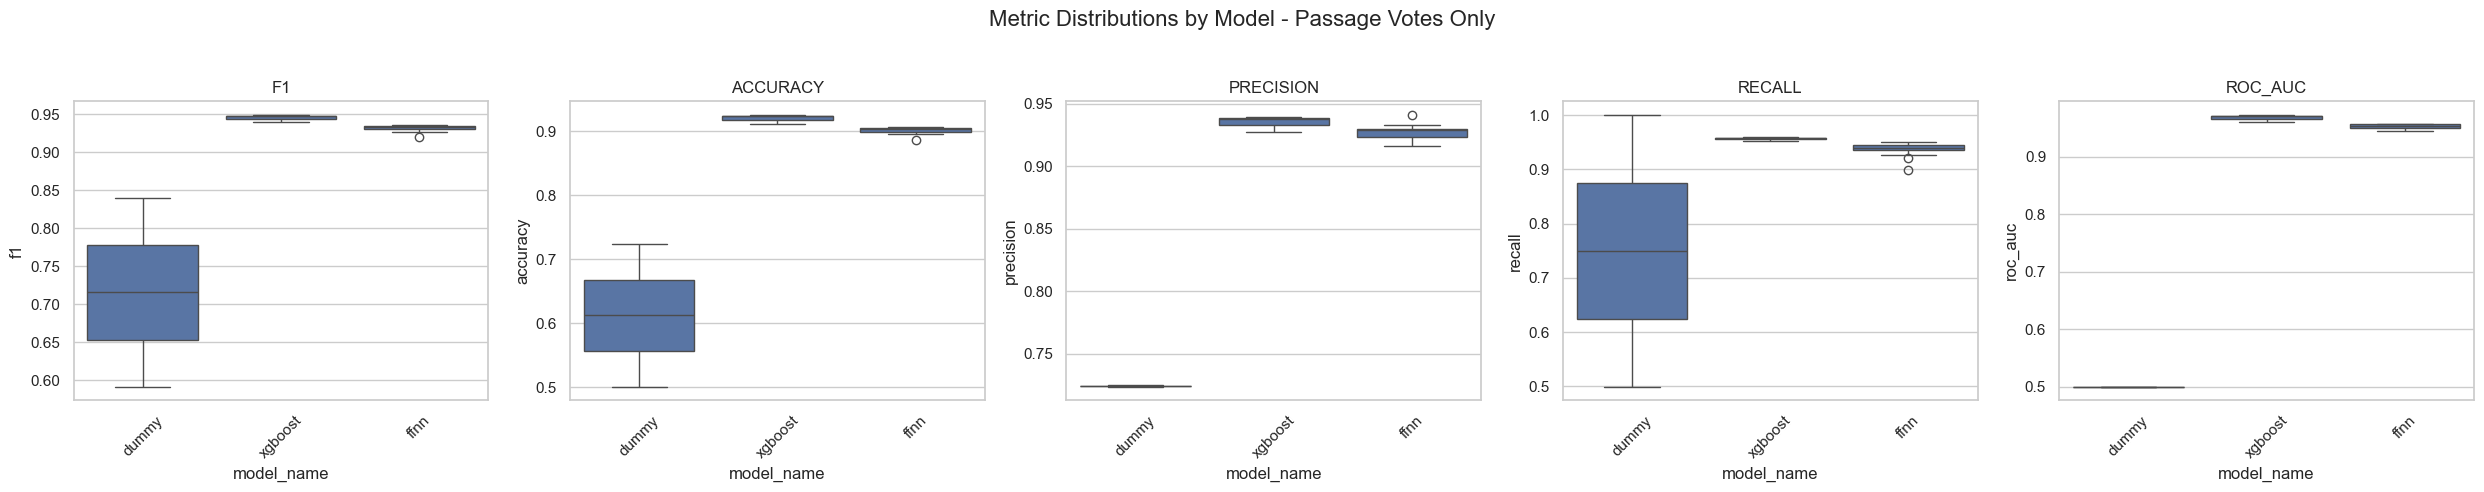

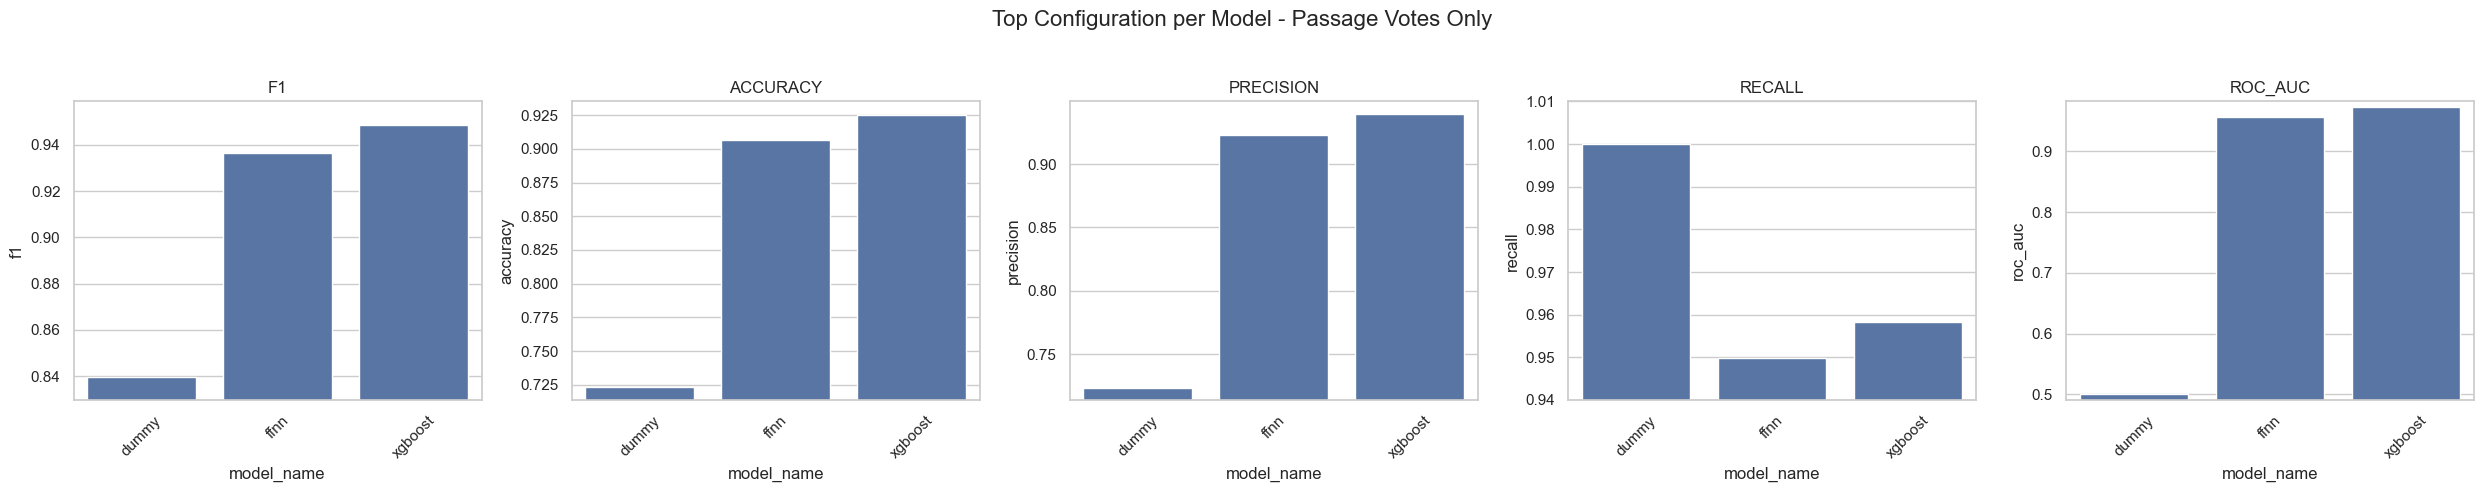

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df['dataset'] = df['model_id'].apply(lambda x: x.split('_')[0])

metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']
datasets = df['dataset'].unique()
sns.set(style="whitegrid")

for dataset in datasets:
    df_subset = df[df['dataset'] == dataset]
    print(dataset)
    dataset = {
        Datasets.V3.value: "Basic",
        Datasets.V6.value: "Advanced",
        "pass": "Passage Votes Only",
    }[dataset]
    
    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f"Metric Distributions by Model - {dataset}", fontsize=16)
    for i, metric in enumerate(metrics):
        sns.boxplot(data=df_subset, x='model_name', y=metric, ax=axs[i])
        axs[i].set_title(metric.upper())
        axs[i].tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    top_per_model = (
        df_subset.sort_values(by=metrics, ascending=False)
        .groupby('model_name', as_index=False)
        .first()
    )

    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f"Top Configuration per Model - {dataset}", fontsize=16)
    for i, metric in enumerate(metrics):
        sns.barplot(data=top_per_model, x='model_name', y=metric, ax=axs[i])
        axs[i].set_title(metric.upper())
        axs[i].tick_params(axis='x', rotation=45)

        vals = top_per_model[metric]
        ymin = vals.min() - 0.01
        ymax = vals.max() + 0.01
        axs[i].set_ylim(ymin, ymax)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

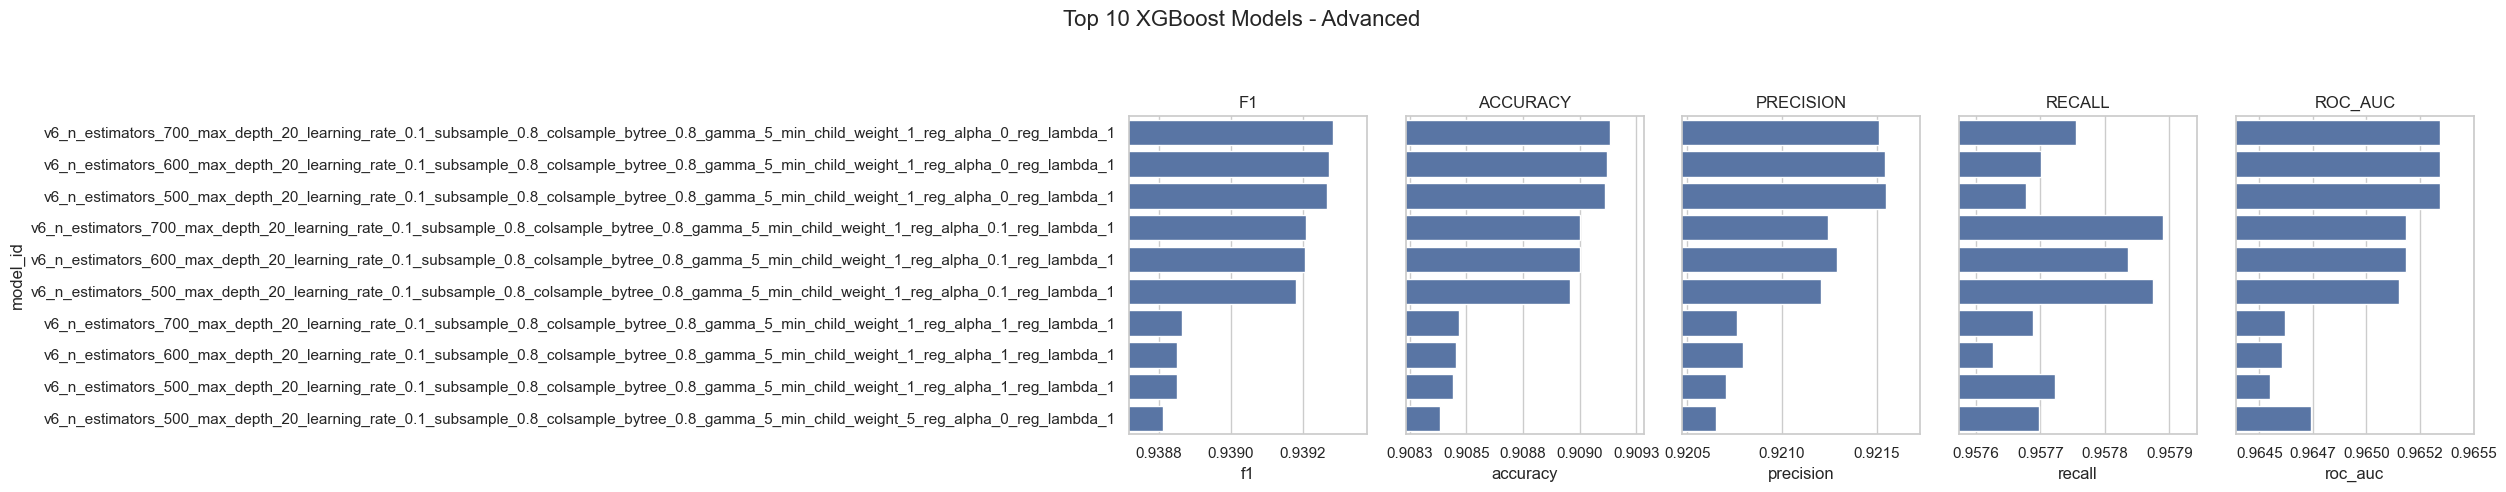

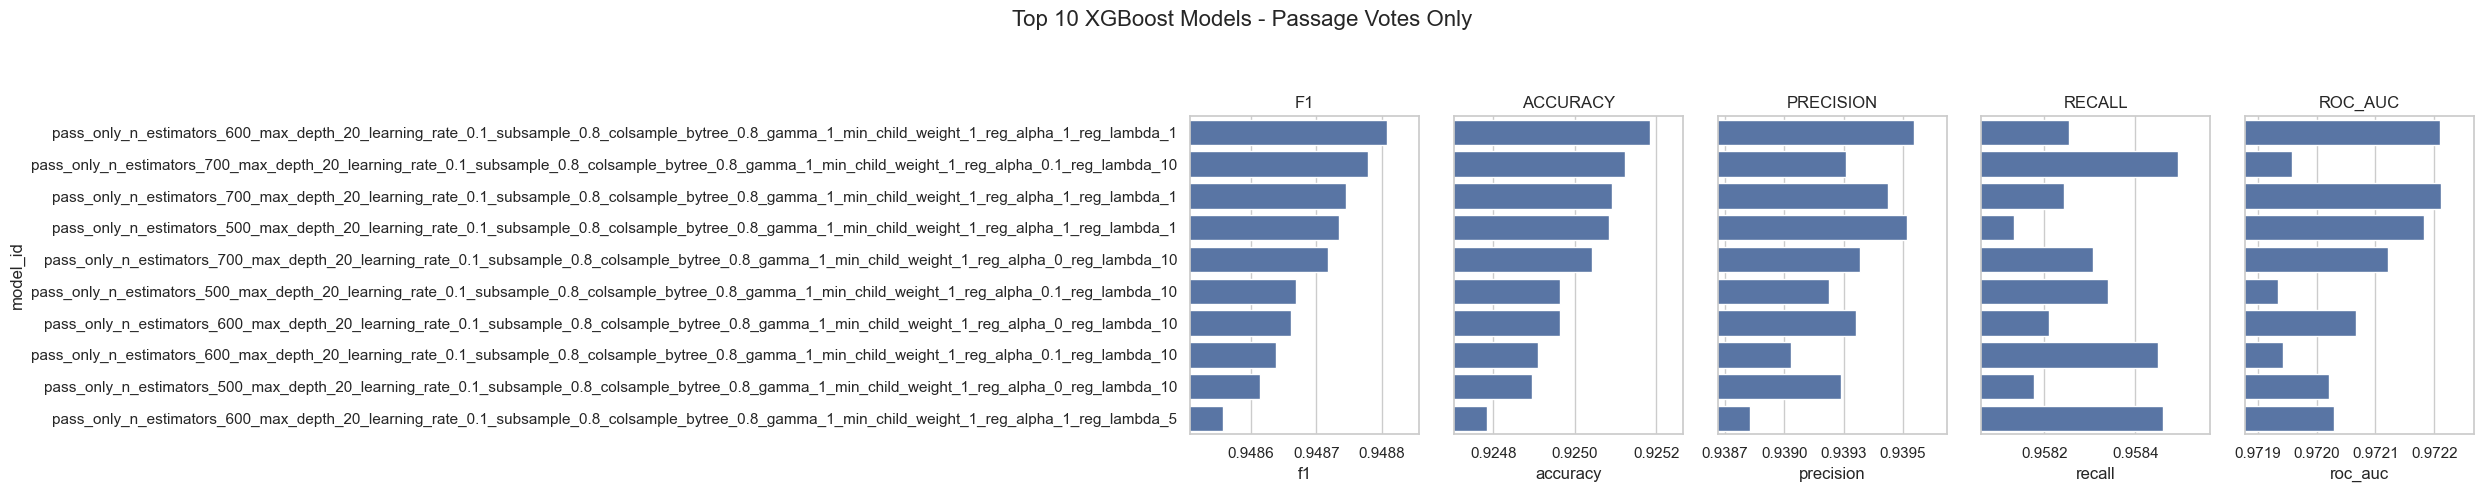

In [9]:
from matplotlib import ticker
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['dataset'] = df['model_id'].apply(lambda x: x.split('_')[0])

xgb_df = df[df['model_name'].str.lower() == 'xgboost'].copy()

metrics = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc']

def plot_grouped_xgb_top10(dataset_name):
    top10 = xgb_df[xgb_df['dataset'] == dataset_name].sort_values(by='f1', ascending=False).head(10).copy()
    top10["model_id"] = top10["model_id"].replace("v6_", "")
    dataset_name = {
        Datasets.V3.value: "Basic",
        Datasets.V6.value: "Advanced",
        "pass": "Passage Votes Only",
    }[dataset_name]

    fig, axs = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5), sharey=True)
    fig.suptitle(f'Top 10 XGBoost Models - {dataset_name}', fontsize=16)

    for i, metric in enumerate(metrics):
        sns.barplot(data=top10, y='model_id', x=metric, ax=axs[i])
        axs[i].set_title(metric.upper())
        min_val = top10[metric].min()
        max_val = top10[metric].max()
        delta = max_val - min_val
        padding = delta * 0.2 if delta > 0 else 0.01
        axs[i].set_xlim(min_val - padding, max_val + padding)
        axs[i].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_grouped_xgb_top10("v6")
plot_grouped_xgb_top10("pass")

/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:47:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


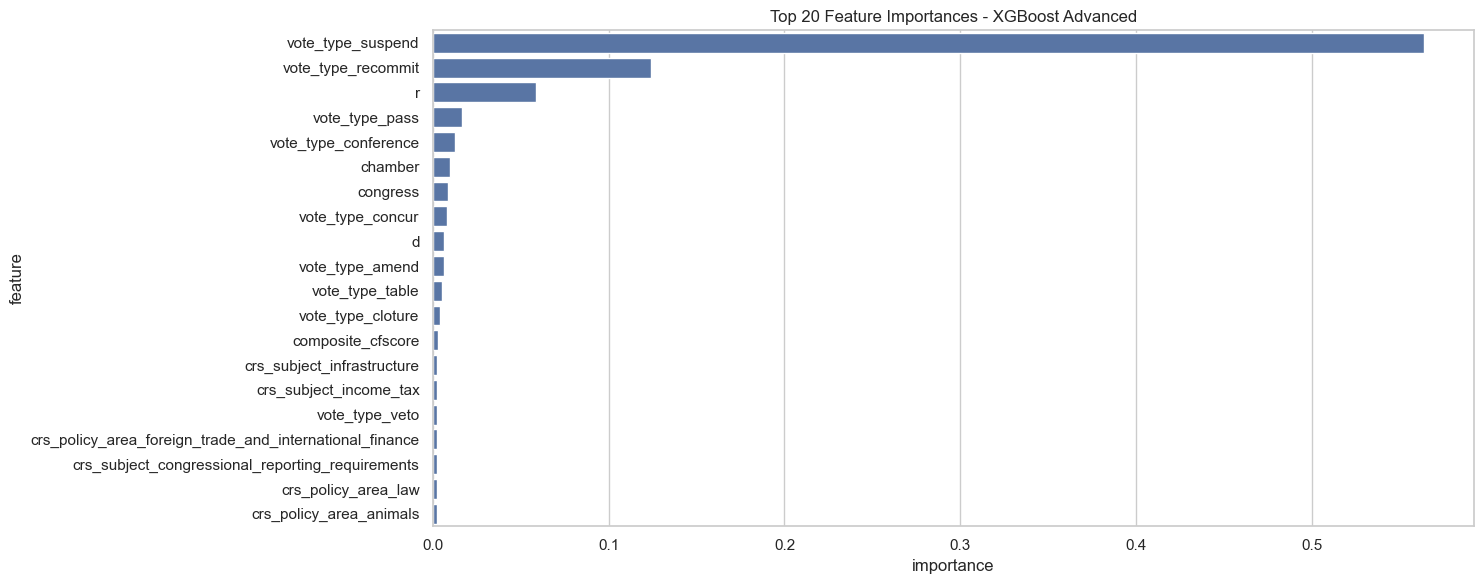

/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:47:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


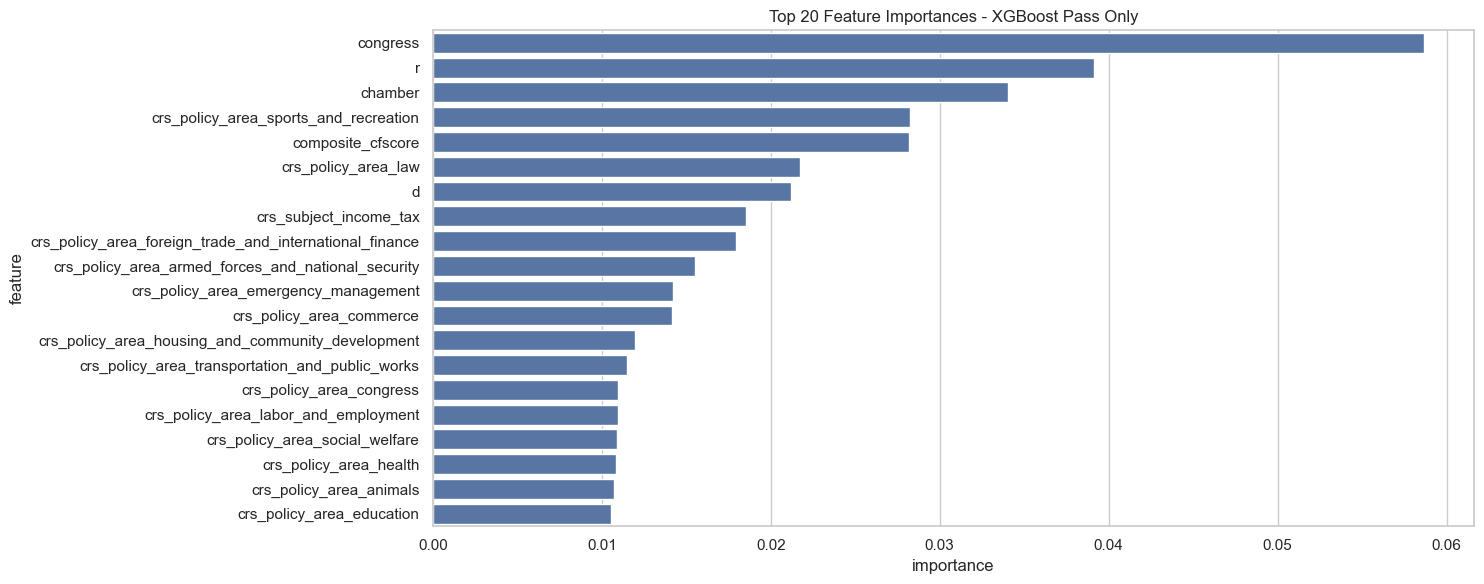

/var/folders/y7/rdkd1_7d3b9fjykc4g2vvjl00000gn/T/ipykernel_34598/4212570643.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df, x='metric', y='score', hue='split', ci=None, hue_order=['train', 'val', 'test'])


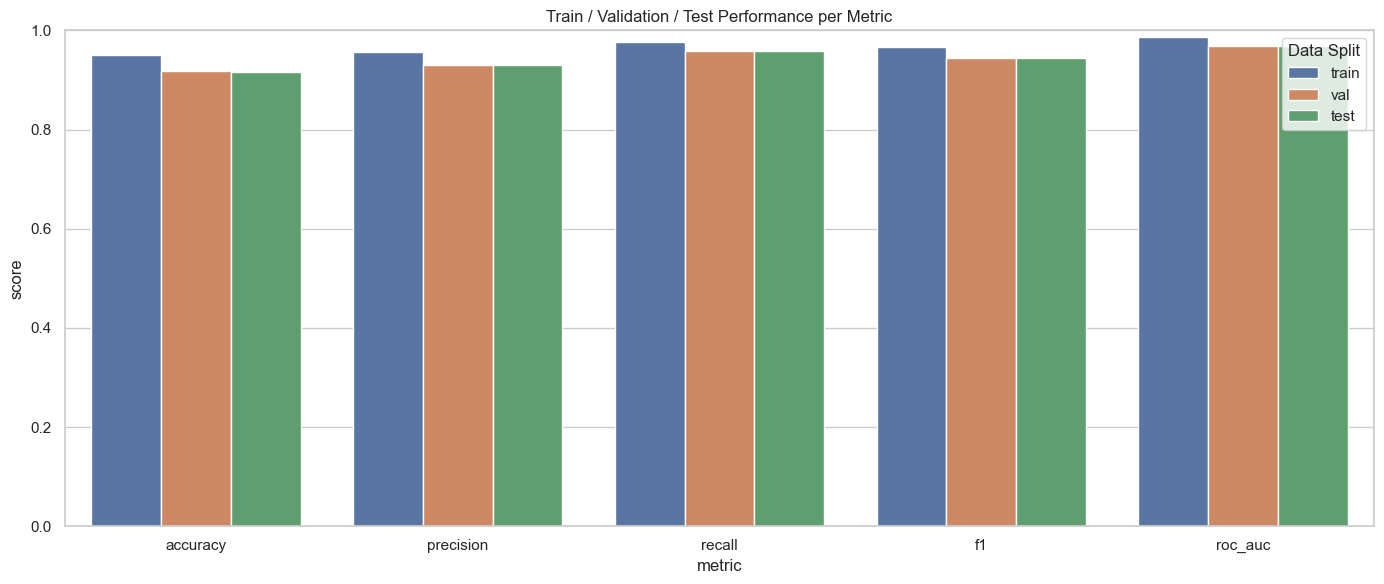

In [10]:


v6_params = {
    "n_estimators": 700, "max_depth": 20, "learning_rate": 0.1,
    "subsample": 0.8, "colsample_bytree": 0.8, "gamma": 5,
    "min_child_weight": 1, "reg_alpha": 0, "reg_lambda": 1, "n_jobs": -1
}

pass_params = {
    "n_estimators": 600, "max_depth": 20, "learning_rate": 0.1,
    "subsample": 0.8, "colsample_bytree": 0.8, "gamma": 1,
    "min_child_weight": 1, "reg_alpha": 1, "reg_lambda": 1, "n_jobs": -1
}

v6_model = XGBoostModel(dataset=Datasets.V6, kwargs_for_model=v6_params, verbose=True)
pass_model = XGBoostModel(dataset=Datasets.PASS_ONLY, kwargs_for_model=pass_params, verbose=True)

def plot_importance(model, feature_names, title, top_n=20):
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_df = feat_df.sort_values(by='importance', ascending=False).head(top_n)
    plt.figure(figsize=(15, 6))
    sns.barplot(data=feat_df, x='importance', y='feature')
    plt.title(f'Top {top_n} Feature Importances - {title}')
    plt.tight_layout()
    plt.show()

    
def run_and_evaluate(model_obj: XGBoostModel, label: str):
    from src.models.evaluation import evaluate_predictions

    target, features, df = model_obj.dataset.get_dataset()
    train_df, val_df, test_df = split_data(df, target_col=target)
    model = model_obj.train(train_df[features], train_df[target])

    results = []
    for split_name, split_df in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
        y_true = split_df[target]
        y_pred, y_prob = model_obj.predict(model, split_df[features])
        metrics = evaluate_predictions(y_true, y_pred, y_prob)

        row = {'model': label, 'split': split_name}
        row.update({k: v for k, v in metrics.items() if k != 'confusion_matrix'})
        results.append(row)

    plot_importance(model, features, title=label)

    return results

results = []
results += run_and_evaluate(v6_model, "XGBoost Advanced")
results += run_and_evaluate(pass_model, "XGBoost Pass Only")

results_df = pd.DataFrame(results)

plot_df = results_df.melt(id_vars=['model', 'split'], 
                          value_vars=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                          var_name='metric', value_name='score')

plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x='metric', y='score', hue='split', ci=None, hue_order=['train', 'val', 'test'])
plt.title("Train / Validation / Test Performance per Metric")
plt.ylim(0.0, 1.0)
plt.legend(title="Data Split")
plt.tight_layout()
plt.show()

/var/folders/y7/rdkd1_7d3b9fjykc4g2vvjl00000gn/T/ipykernel_34598/845249172.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df.loc[plot_df["model"].str.contains("Advanced")], x='metric', y='score', hue='split', ci=None, hue_order=['train', 'val', 'test'])


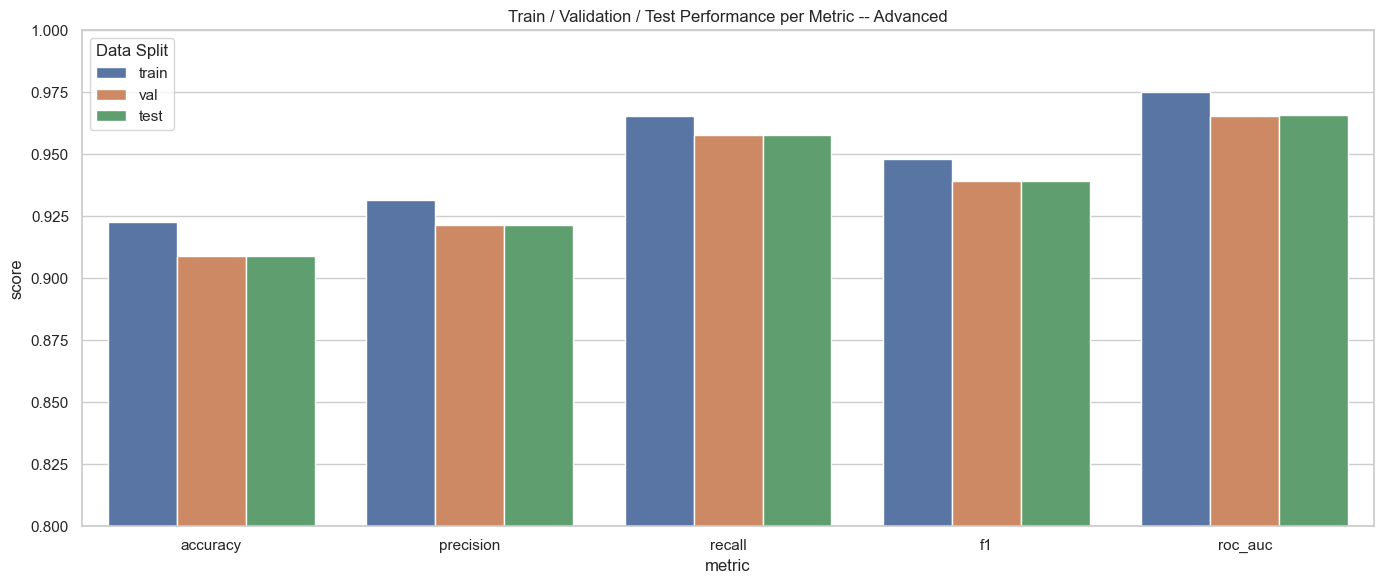

In [11]:
plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df.loc[plot_df["model"].str.contains("Advanced")], x='metric', y='score', hue='split', ci=None, hue_order=['train', 'val', 'test'])
plt.title("Train / Validation / Test Performance per Metric -- Advanced")
plt.ylim(0.8, 1.0)
plt.legend(title="Data Split")
plt.tight_layout()
plt.show()

/var/folders/y7/rdkd1_7d3b9fjykc4g2vvjl00000gn/T/ipykernel_34598/2125593828.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_df.loc[plot_df["model"].str.contains("Pass")], x='metric', y='score', hue='split', ci=None, hue_order=['train', 'val', 'test'])


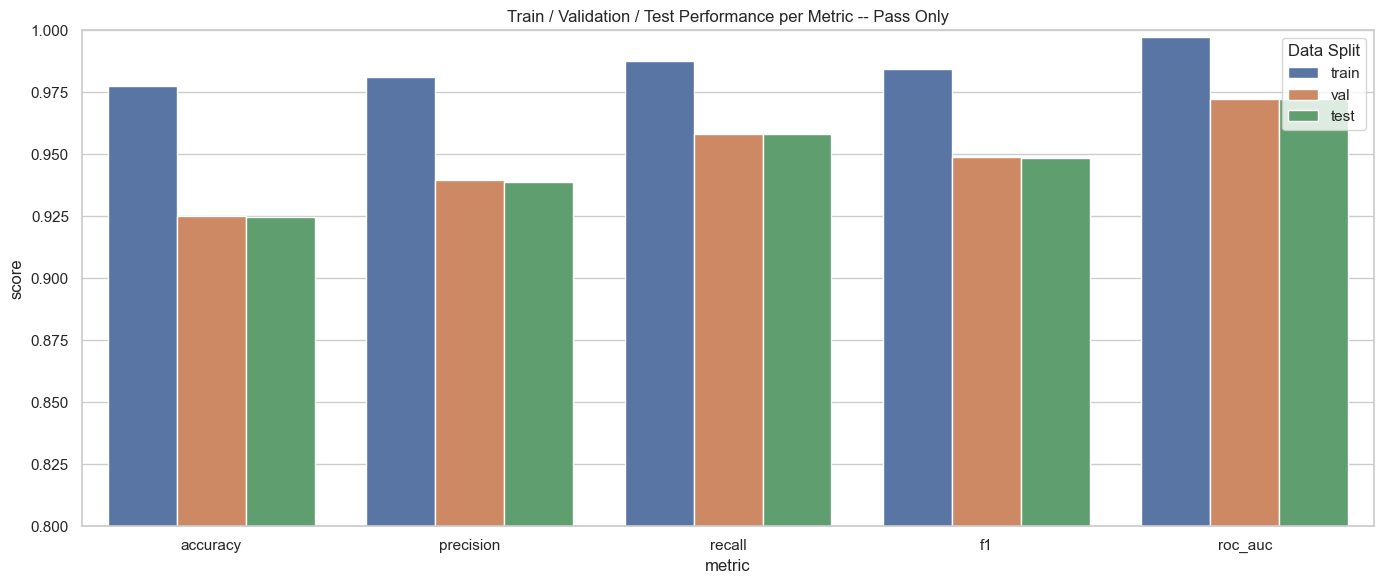

In [12]:
plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df.loc[plot_df["model"].str.contains("Pass")], x='metric', y='score', hue='split', ci=None, hue_order=['train', 'val', 'test'])
plt.title("Train / Validation / Test Performance per Metric -- Pass Only")
plt.ylim(0.8, 1.0)
plt.legend(title="Data Split")
plt.tight_layout()
plt.show()

In [13]:
model = XGBoostModel(kwargs_for_model=pass_params, dataset=Datasets.PASS_ONLY)
target, features, df = model.dataset.get_dataset()
train_df, val_df, test_df = split_data(df, target_col=target)
model = model.train(train_df[features], train_df[target])

/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:47:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


getting shap values
getting summary plot


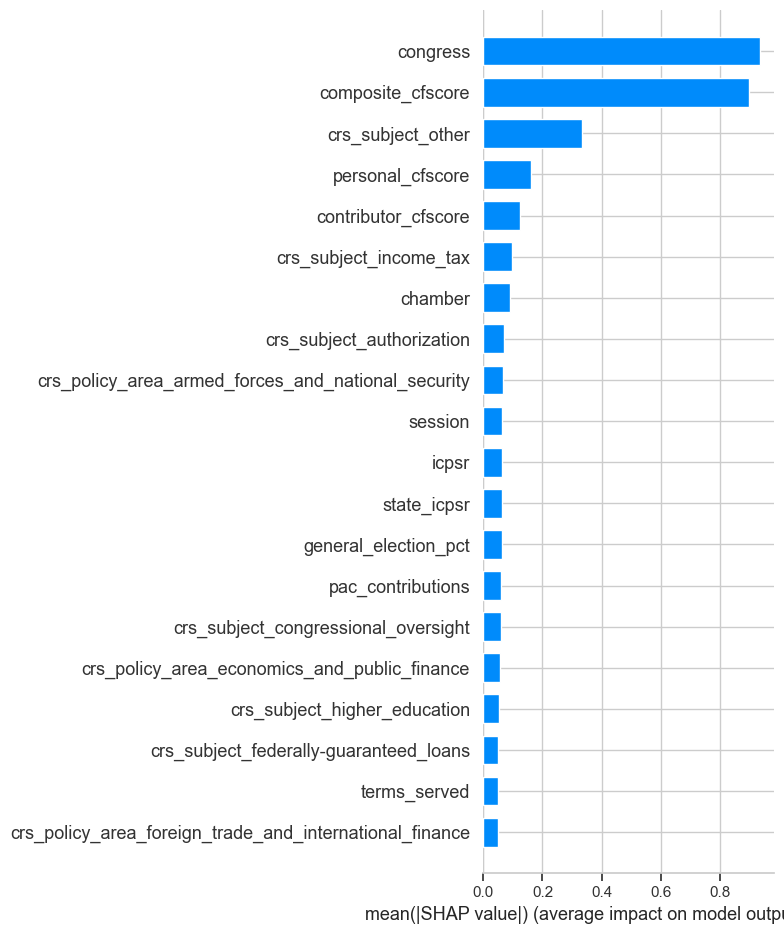

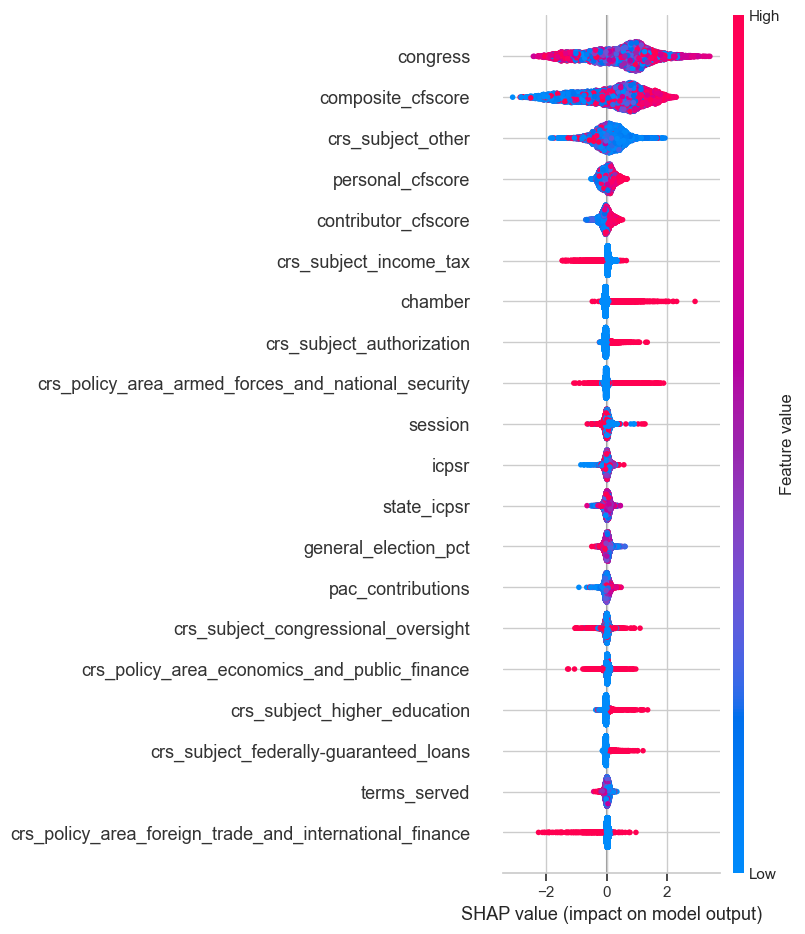

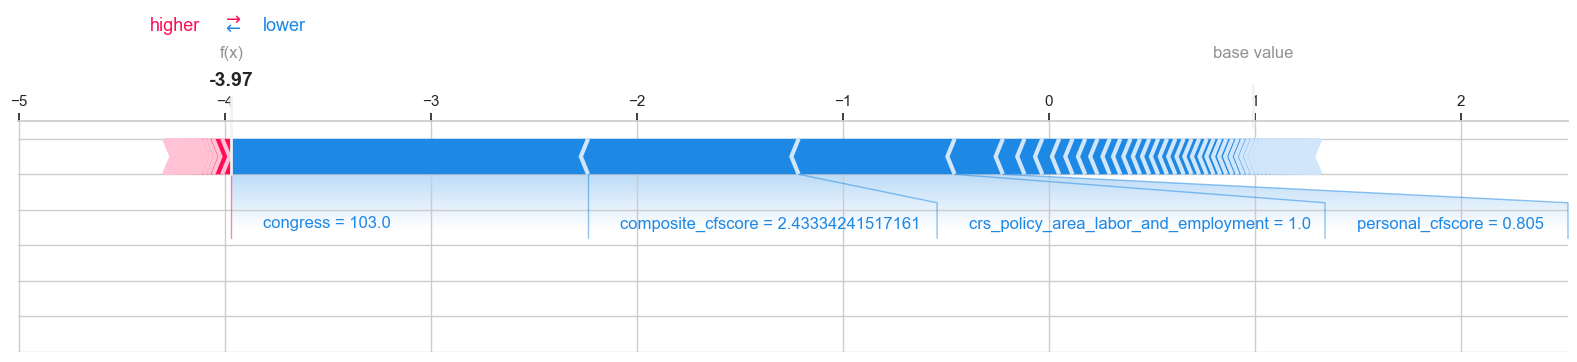

In [18]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

explainer = shap.TreeExplainer(model)
target, features, df = Datasets.PASS_ONLY.get_dataset()
train_df, val_df, test_df = split_data(df, target_col=target)
test_df = test_df.sample(n=10_000, random_state=42)

print('getting shap values')
shap_values = explainer.shap_values(test_df[features])
print('getting summary plot')
shap.summary_plot(shap_values, test_df[features], plot_type="bar")
shap.summary_plot(shap_values, test_df[features])

row_idx = 0 
shap.force_plot(
    explainer.expected_value, shap_values[row_idx], test_df[features].iloc[row_idx],
    matplotlib=True
)

/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/declannelson/Desktop/columbia/stat5241/stat5241_team_7/env/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  war

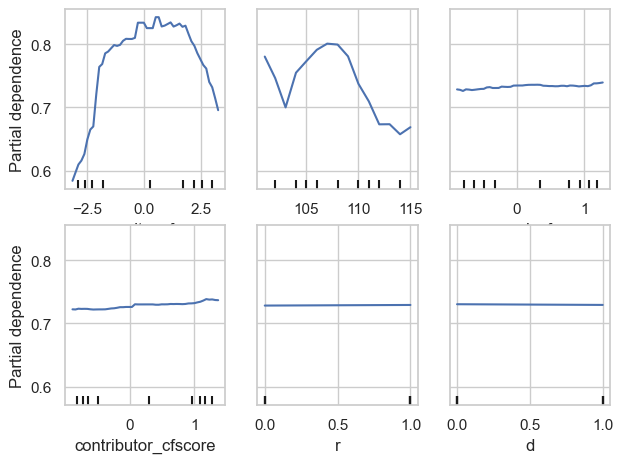

In [21]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = ['composite_cfscore', 'congress', 'personal_cfscore', 'contributor_cfscore', 'r', 'd']
target, features, df = Datasets.PASS_ONLY.get_dataset()
train_df, val_df, test_df = split_data(df, target_col=target)

PartialDependenceDisplay.from_estimator(
    model,
    test_df[features],
    features=features_to_plot,
    kind="average",  
    grid_resolution=50, 
    n_jobs=-1
)

plt.tight_layout()
plt.show()